In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ADANIPORTS.csv to ADANIPORTS.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Quote-Equity-ADANIPORTS-EQ-05-04-2024-to-19-10-2024.csv to Quote-Equity-ADANIPORTS-EQ-05-04-2024-to-19-10-2024.csv


In [ ]:
#all imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split,learning_curve, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
test=pd.read_csv('Quote-Equity-ADANIPORTS-EQ-05-04-2024-to-19-10-2024.csv')
test.rename(columns=lambda x: x.strip(), inplace=True)
test = test.drop(columns=['series','ltp','52W H','52W L','VALUE','No of trades'])
test['Date']=pd.to_datetime(test['Date'])
new_order = ['Date','PREV. CLOSE','OPEN','HIGH', 'LOW', 'close','vwap','VOLUME']
test = test.reindex(columns=new_order)
test.rename(columns={'close':'Close','PREV. CLOSE':'Prev Close','OPEN':'Open','HIGH':'High','LOW':'Low','vwap':'VWAP','VOLUME':'Volume'}, inplace=True)
test.head()

,Date,Prev Close,Open,High,Low,Close,VWAP,Volume
0,2024-10-18,"1,394.70","1,389.00","1,410.55","1,376.00","1,405.60","1,398.94","12,90,065"
1,2024-10-17,"1,403.80","1,403.80","1,408.00","1,387.55","1,394.70","1,397.01","14,18,861"
2,2024-10-16,"1,420.30","1,418.00","1,418.40","1,392.00","1,403.80","1,404.69","14,50,465"
3,2024-10-15,"1,410.30","1,415.95","1,424.70","1,407.00","1,420.30","1,417.81","10,18,477"
4,2024-10-14,"1,408.25","1,418.00","1,426.00","1,407.15","1,410.30","1,414.48","7,62,384"


In [ ]:
#checking for empty values in test set
print(test.isnull().sum())
duplicate_rows = test.duplicated()
print(duplicate_rows.sum())
test['High'] = test['High'].str.replace(',', '').astype(float)
test['Low'] = test['Low'].str.replace(',', '').astype(float)
test['Open'] = test['Open'].str.replace(',', '').astype(float)
test['Prev Close'] = test['Prev Close'].str.replace(',', '').astype(float)
test['Close'] = test['Close'].str.replace(',', '').astype(float)
test['VWAP'] = test['VWAP'].str.replace(',', '').astype(float)
test['Volume'] = test['Volume'].str.replace(',', '').astype(float)
print(test.dtypes)

Date          0
Prev Close    0
Open          0
High          0
Low           0
Close         0
VWAP          0
Volume        0
dtype: int64
0
Date          datetime64[ns]
Prev Close           float64
Open                 float64
High                 float64
Low                  float64
Close                float64
VWAP                 float64
Volume               float64
dtype: object


In [ ]:
df=pd.read_csv('ADANIPORTS.csv')
df = df.drop(['Symbol','Series','Trades','Last','Deliverable Volume','%Deliverble','Turnover'],axis=1)
df.head()

,Date,Prev Close,Open,High,Low,Close,VWAP,Volume
0,2007-11-27,440.00,770.00,1050.00,770.0,962.90,984.72,27294366
1,2007-11-28,962.90,984.00,990.00,874.0,893.90,941.38,4581338
2,2007-11-29,893.90,909.00,914.75,841.0,884.20,888.09,5124121
3,2007-11-30,884.20,890.00,958.00,890.0,921.55,929.17,4609762
4,2007-12-03,921.55,939.75,995.00,922.0,969.30,965.65,2977470


In [ ]:
print(df.isnull().sum())
duplicate_rows = df.duplicated()
print(duplicate_rows.sum())

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_out = remove_outliers_iqr(df, 'Prev Close')
df_out = remove_outliers_iqr(df_out, 'Open')
df_out = remove_outliers_iqr(df_out, 'High')
df_out = remove_outliers_iqr(df_out, 'Low')
#df_out = remove_outliers_iqr(df_out, 'Last')
df_out = remove_outliers_iqr(df_out, 'Close')
df_out = remove_outliers_iqr(df_out, 'VWAP')
df_out = remove_outliers_iqr(df_out, 'Volume')
# df_out = remove_outliers_iqr(df_out, 'Turnover')
# df_out = remove_outliers_iqr(df_out, 'Deliverable Volume')
# df_out = remove_outliers_iqr(df_out, '%Deliverble')
df_out.reset_index(drop=True, inplace=True)
df_out

Date          0
Prev Close    0
Open          0
High          0
Low           0
Close         0
VWAP          0
Volume        0
dtype: int64
0


,Date,Prev Close,Open,High,Low,Close,VWAP,Volume
0,2008-03-13,602.90,585.0,600.00,562.05,566.30,579.98,165515
1,2008-03-14,566.30,569.0,577.00,554.05,561.00,561.01,157189
2,2008-03-17,561.00,549.0,549.00,507.00,511.45,524.19,201577
3,2008-03-18,511.45,505.0,525.00,490.00,502.40,505.47,257617
4,2008-03-19,502.40,530.0,530.00,495.00,497.75,510.00,196021
...,...,...,...,...,...,...,...,...
2667,2021-01-15,536.95,536.8,541.00,524.00,527.95,531.23,5427713
2668,2021-01-18,527.95,531.0,532.30,503.80,515.50,517.81,6258367
2669,2021-01-25,535.80,543.0,547.45,522.00,523.65,532.01,5816153
2670,2021-01-28,518.85,515.7,527.95,507.05,519.10,519.12,5707393


In [ ]:
#feautre engineering
#code for feature engineering
df_out['price_change'] = df_out['Close'] - df_out['Open']
df_out['returns'] = df_out['Close'].pct_change()
df_out['average_price'] = (df_out['Close'] + df_out['Open']) / 2
df_out['price_range'] = df_out['High'] - df_out['Low']
df_out['volume_change'] = df_out['Volume'].diff()
df_out['price_volume_correlation'] = df_out['Close'].corr(df_out['Volume'])
df_out['returns_volume_correlation'] = df_out['returns'].corr(df_out['Volume']) #correlation add to paper
df_out['price_volume_covariance'] = df_out['Close'].cov(df_out['Volume']) #covariance add to paper
df_out['returns_volume_covariance'] = df_out['returns'].cov(df_out['Volume'])
df_out['moving_average_5'] = df_out['Close'].rolling(window=5).mean()
df_out['moving_average_10'] = df_out['Close'].rolling(window=10).mean()
df_out['moving_average_20'] = df_out['Close'].rolling(window=20).mean()
df_out['exponential_moving_average_5'] = df_out['Close'].ewm(span=5).mean()
df_out['exponential_moving_average_10'] = df_out['Close'].ewm(span=10).mean()
df_out['exponential_moving_average_20'] = df_out['Close'].ewm(span=20).mean()
df_out['exponential_moving_average_12'] = df_out['Close'].ewm(span=12).mean()
df_out['exponential_moving_average_26'] = df_out['Close'].ewm(span=26).mean()
df_out['macd'] = df_out['exponential_moving_average_12'] - df_out['exponential_moving_average_26']

#for test set
test['price_change'] = test['Close'] - test['Open']
test['returns'] = test['Close'].pct_change()
test['average_price'] = (test['Close'] + test['Open']) / 2
test['price_range'] = test['High'] - test['Low']
test['volume_change'] = test['Volume'].diff()
test['price_volume_correlation'] = test['Close'].corr(test['Volume'])
test['returns_volume_correlation'] = test['returns'].corr(test['Volume']) #correlation add to paper
test['price_volume_covariance'] = test['Close'].cov(test['Volume']) #covariance add to paper
test['returns_volume_covariance'] = test['returns'].cov(test['Volume'])
test['moving_average_5'] = test['Close'].rolling(window=5).mean()
test['moving_average_10'] = test['Close'].rolling(window=10).mean()
test['moving_average_20'] = test['Close'].rolling(window=20).mean()
test['exponential_moving_average_5'] = test['Close'].ewm(span=5).mean()
test['exponential_moving_average_10'] = test['Close'].ewm(span=10).mean()
test['exponential_moving_average_20'] = test['Close'].ewm(span=20).mean()
test['exponential_moving_average_12'] = test['Close'].ewm(span=12).mean()
test['exponential_moving_average_26'] = test['Close'].ewm(span=26).mean()
test['macd'] = test['exponential_moving_average_12'] - test['exponential_moving_average_26']

In [ ]:
df_2 = df_out.drop(columns=['Date'])
test_2 = test.drop(columns=['Date'])

In [ ]:
#handling nan Values
df_2.interpolate(method='bfill',inplace=True)
test_2.interpolate(method='bfill',inplace=True)

<ipython-input-10-122d9238c73f>:2: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_2.interpolate(method='bfill',inplace=True)
<ipython-input-10-122d9238c73f>:3: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_2.interpolate(method='bfill',inplace=True)


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df_2)
X = pd.DataFrame(X, columns=df_2.columns)

scaler = StandardScaler()
test_x = scaler.fit_transform(test_2)
test_x = pd.DataFrame(test_x, columns=test_2.columns)

df_date = df_out['Date']
test_date = test['Date']
X = pd.concat([df_date, X], axis=1)
test_x = pd.concat([test_date, test_x], axis=1)
test_x

,Date,Prev Close,Open,High,Low,Close,VWAP,Volume,price_change,returns,...,returns_volume_covariance,moving_average_5,moving_average_10,moving_average_20,exponential_moving_average_5,exponential_moving_average_10,exponential_moving_average_20,exponential_moving_average_12,exponential_moving_average_26,macd
0,2024-10-18,-0.451569,-0.586087,-0.508926,-0.437232,-0.311530,-0.405025,-0.500337,0.601427,-0.266849,...,-1.818989e-12,-0.327343,-0.400068,-0.167538,-0.350727,-0.393662,-0.502892,-0.413212,-0.578471,0.291921
1,2024-10-17,-0.330889,-0.388173,-0.543575,-0.290455,-0.456396,-0.431072,-0.478001,-0.156724,-0.266849,...,-1.818989e-12,-0.327343,-0.400068,-0.167538,-0.445507,-0.485602,-0.601946,-0.505858,-0.684283,0.276427
2,2024-10-16,-0.112075,-0.198283,-0.402263,-0.233904,-0.335453,-0.327423,-0.472520,-0.307175,0.212957,...,-1.818989e-12,-0.327343,-0.400068,-0.167538,-0.412968,-0.459740,-0.577014,-0.480722,-0.658357,0.290057
3,2024-10-15,-0.244690,-0.225697,-0.316660,-0.043283,-0.116162,-0.150357,-0.547437,0.240051,0.388662,...,-1.818989e-12,-0.327343,-0.400068,-0.167538,-0.298621,-0.363698,-0.482161,-0.386599,-0.559194,0.334045
4,2024-10-14,-0.271876,-0.198283,-0.298996,-0.041377,-0.249066,-0.195299,-0.591850,-0.115424,-0.242860,...,-1.818989e-12,-0.327343,-0.400068,-0.167538,-0.292475,-0.351608,-0.467497,-0.373792,-0.543287,0.331850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2024-04-12,-1.013857,-1.107616,-1.217526,-0.882014,-1.127560,-1.072396,-0.345440,-0.059374,0.725486,...,-1.818989e-12,-1.660770,-1.679849,-2.153001,-1.563431,-1.725967,-1.916936,-1.775220,-1.978952,-0.461421
130,2024-04-10,-0.958159,-0.987263,-1.197144,-0.790516,-1.019908,-1.032718,-0.033141,-0.085924,0.196196,...,-1.818989e-12,-1.539484,-1.638316,-2.114511,-1.416678,-1.632350,-1.870132,-1.694352,-1.949026,-0.236318
131,2024-04-09,-1.062261,-1.025375,-1.129206,-0.817203,-0.964088,-0.978465,-0.388350,0.122051,0.098078,...,-1.818989e-12,-1.364724,-1.599408,-2.039250,-1.298554,-1.544043,-1.820861,-1.615785,-1.915500,-0.032708
132,2024-04-08,-0.705527,-0.680363,-0.897535,-0.932846,-1.068418,-1.056741,1.710625,-0.870626,-0.200730,...,-1.818989e-12,-1.237704,-1.557201,-1.951956,-1.257727,-1.493681,-1.789223,-1.568256,-1.895329,0.090841


In [ ]:
#dealing with the date
X = X.sort_values(by='Date')
test_x = test_x.sort_values(by='Date')
date = X['Date']
date2 = test_x['Date']
date = pd.to_datetime(date)

In [ ]:
X['Date'] = pd.to_datetime(X['Date'])
X = X.set_index('Date')
test_x = test_x.set_index('Date')
#taking target variable
y = X['Close']
test_y = test_x['Close']
test_x = test_x.drop(columns=['Close'])
X = X.drop(columns=['Close'])
test_y

,Close
Date,
2024-04-05,-0.710906
2024-04-08,-1.068418
2024-04-09,-0.964088
2024-04-10,-1.019908
2024-04-12,-1.127560
...,...
2024-10-14,-0.249066
2024-10-15,-0.116162
2024-10-16,-0.335453


In [ ]:
#feature selection
selector = ElasticNet()
selector.fit(X, y)
coefficients = selector.coef_

feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

selected_features = feature_importance[feature_importance['Coefficient'] != 0]['Feature']

X = X[selected_features].copy()
test_x = test_x[selected_features].copy()

test_x.head()

,Prev Close,Open,High,Low,VWAP,average_price,moving_average_5,moving_average_10,moving_average_20,exponential_moving_average_5,exponential_moving_average_10,exponential_moving_average_20,exponential_moving_average_12,exponential_moving_average_26
Date,,,,,,,,,,,,,,
2024-04-05,-0.820902,-0.880282,-0.898214,-0.674237,-0.781560,-0.816444,-1.065667,-1.477060,-1.869525,-1.100560,-1.377468,-1.716253,-1.463100,-1.839398
2024-04-08,-0.705527,-0.680363,-0.897535,-0.932846,-1.056741,-0.898213,-1.237704,-1.557201,-1.951956,-1.257727,-1.493681,-1.789223,-1.568256,-1.895329
2024-04-09,-1.062261,-1.025375,-1.129206,-0.817203,-0.978465,-1.021038,-1.364724,-1.599408,-2.039250,-1.298554,-1.544043,-1.820861,-1.615785,-1.915500
2024-04-10,-0.958159,-0.987263,-1.197144,-0.790516,-1.032718,-1.030276,-1.539484,-1.638316,-2.114511,-1.416678,-1.632350,-1.870132,-1.694352,-1.949026
2024-04-12,-1.013857,-1.107616,-1.217526,-0.882014,-1.072396,-1.147284,-1.660770,-1.679849,-2.153001,-1.563431,-1.725967,-1.916936,-1.775220,-1.978952


In [ ]:
X

,Prev Close,Open,High,Low,VWAP,average_price,moving_average_5,moving_average_10,moving_average_20,exponential_moving_average_5,exponential_moving_average_10,exponential_moving_average_20,exponential_moving_average_12,exponential_moving_average_26
Date,,,,,,,,,,,,,,
2008-03-13,2.577262,2.418799,2.461416,2.321865,2.381765,2.352076,1.977695,1.916073,1.787906,2.294535,2.305486,2.324082,2.309526,2.333645
2008-03-14,2.279782,2.289201,2.278134,2.255804,2.228004,2.265587,1.977695,1.916073,1.787906,2.268534,2.281536,2.301027,2.285897,2.310739
2008-03-17,2.236704,2.127203,2.055008,1.867282,1.929561,1.983181,1.977695,1.916073,1.787906,2.068416,2.110005,2.142608,2.118912,2.154938
2008-03-18,1.833968,1.770808,1.863758,1.726902,1.777827,1.767772,1.977695,1.916073,1.787906,1.945316,2.001441,2.042146,2.013057,2.056210
2008-03-19,1.760411,1.973305,1.903602,1.768190,1.814544,1.850403,1.977695,1.916073,1.787906,1.864212,1.927042,1.972949,1.940307,1.988230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-15,2.041229,2.028384,1.991258,2.007662,1.986623,2.000641,1.824146,1.691114,1.310379,1.853972,1.691240,1.423243,1.630067,1.306139
2021-01-18,1.968078,1.981405,1.921930,1.840857,1.877848,1.926537,1.876010,1.730868,1.381723,1.862373,1.727034,1.468949,1.670271,1.350930
2021-01-25,2.031882,2.078604,2.042657,1.991146,1.992946,2.008356,1.915541,1.770294,1.444500,1.890187,1.768495,1.516734,1.714611,1.397428


In [ ]:
# Calculate the sizes
train_size = int(len(X) * 0.7)  # 70% for training
val_size = int(len(X) * 0.15)    # 15% for validation
test_size = len(X) - train_size - val_size  # Remaining for testing

# Create the splits
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Check the date ranges
print("Train dates:", X_train.index.min(), "to", X_train.index.max())
print("Validation dates:", X_val.index.min(), "to", X_val.index.max())
print("Test dates:", X_test.index.min(), "to", X_test.index.max())

Train dates: 2008-03-13 00:00:00 to 2017-04-27 00:00:00
Validation dates: 2017-04-28 00:00:00 to 2019-01-18 00:00:00
Test dates: 2019-01-21 00:00:00 to 2021-02-05 00:00:00


In [ ]:
model = RandomForestRegressor(n_estimators=150, random_state=45, n_jobs=-1, min_samples_leaf = 1, max_depth=7)

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=150, n_jobs=-1, random_state=45)

In [ ]:
#analyzing the training split
predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, predictions)
r2 = r2_score(y_train, predictions)
mape = mean_absolute_percentage_error(y_train, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"r2: {r2}")
print(f"MAPE: {mape}")

Mean Squared Error: 0.000283519826656486
Root Mean Squared Error: 0.016838046996504256
Mean Absolute Error: 0.01139949446209472
r2: 0.9997355993639724
MAPE: 0.18417608510336594


In [ ]:
#analyzing the validation split and tuning
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
print(f"Mean Squared Error: {val_mse}")
print(f"Root Mean Squared Error: {val_rmse}")
print(f"Mean Absolute Error: {val_mae}")
print(f"r2: {val_r2}")
print(f"MAPE: {val_mape}")
#increasing the training data imporves the performace of the validation split

Mean Squared Error: 0.0007979065161464887
Root Mean Squared Error: 0.028247239088917853
Mean Absolute Error: 0.022336584341116447
r2: 0.9830595291951926
MAPE: 0.03206278365262308


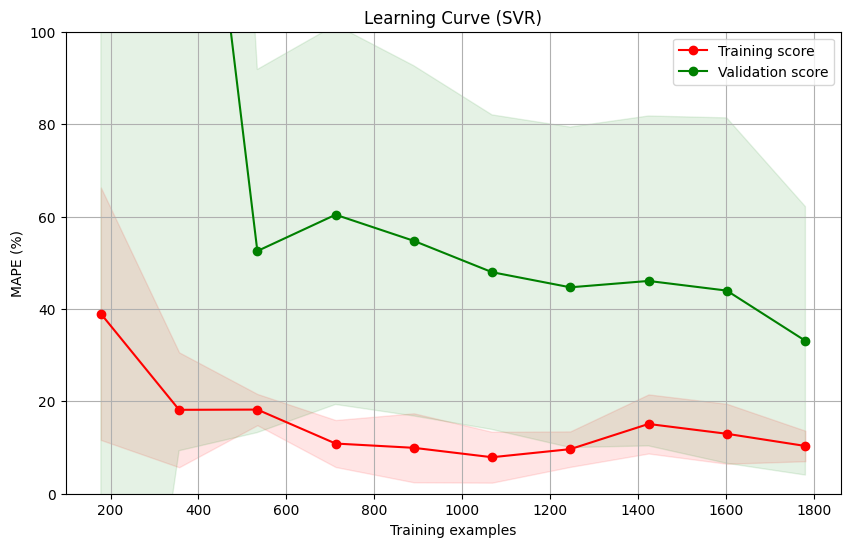

In [ ]:
#checking the learning curve of validation split and training split
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true) else np.inf # if np.all(y_true) checks if the values are zero then returns infinty

def mape2(y_true, y_pred):
    # Avoid division by zero and handle cases where y_true contains zeros
    if np.any(y_true == 0):
        return np.inf  # or a large number to signify invalid MAPE
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring=make_scorer(mape), cv=3, n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (SVR)")
plt.xlabel("Training examples")
plt.ylabel("MAPE (%)")
plt.grid()

# Plotting training scores
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

# Plotting validation scores
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

plt.legend(loc="best")
plt.ylim(0, 100)  # Adjust as necessary for MAPE
plt.show()



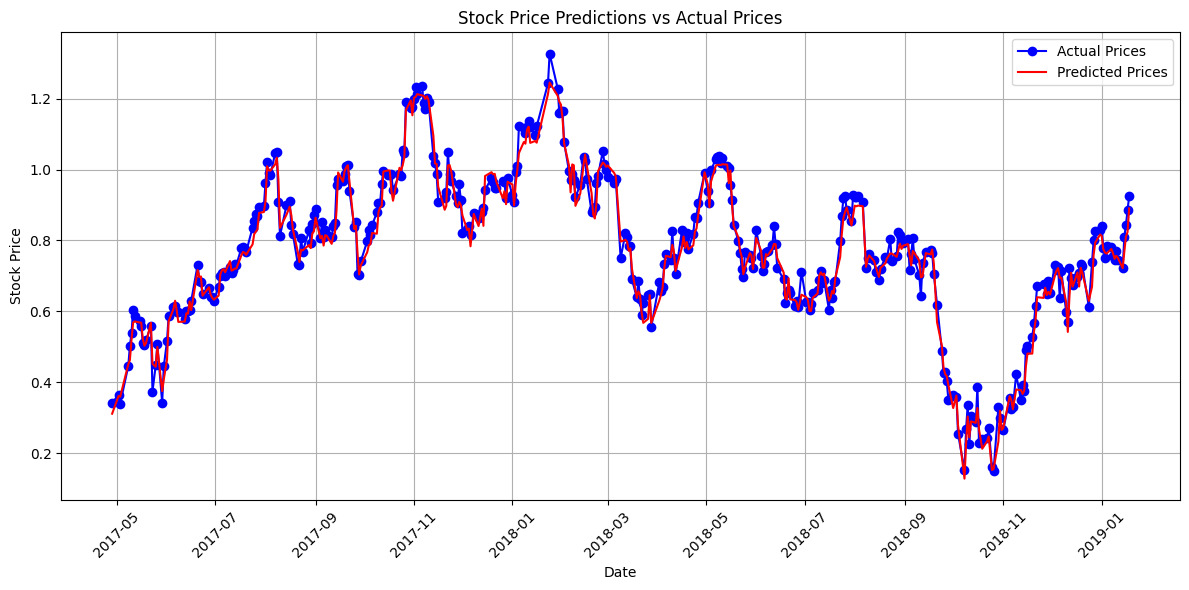

In [ ]:
# Validation dates
start_validation_date = '2017-04-28'
end_validation_date = '2019-01-18'

# Filter the date array for the validation period
plot_date = date[(date >= start_validation_date) & (date <= end_validation_date)]


#Visiualizing the predictions
plot_y_val = np.array(y_val)
plot_val_predictions = np.array(val_predictions)

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(plot_date,plot_y_val, label='Actual Prices', color='blue', marker='o')
plt.plot(plot_date,plot_val_predictions, label='Predicted Prices', color='red', linestyle='-',)

# Adding titles and labels
plt.title('Stock Price Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#lets do some cross validation
param_dist = {
    'n_estimators': [100,150, 200, 300, 400, 500],
   # 'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5,7,9,10,12,20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2,3, 4,5, 6],
    'bootstrap': [True, False],
}


random_search = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions = param_dist,
    n_iter = 80,
    cv = TimeSeriesSplit(n_splits = 5),
    scoring = 'neg_mean_absolute_error',
    random_state = 42,
    return_train_score=True
)

random_search.fit(X_train, y_train)

pd.set_option('display.max_columns', None)
results_df = pd.DataFrame({
    'params': random_search.cv_results_['params'],
    'rank_test_score': random_search.cv_results_['rank_test_score'],
    'mean_test_score': random_search.cv_results_['mean_test_score'],
    'std_test_score': random_search.cv_results_['std_test_score'],
    'mean_train_score': random_search.cv_results_['mean_train_score'],
    'std_train_score': random_search.cv_results_['std_train_score']
})
results_df.sort_values(by='rank_test_score', inplace=True)
results_df

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
1,"{'n_estimators': 200, 'min_samples_split': 2, ...",1,-0.190057,0.325330,-0.010515,0.004099
73,"{'n_estimators': 100, 'min_samples_split': 5, ...",2,-0.190163,0.325645,-0.011217,0.004418
72,"{'n_estimators': 400, 'min_samples_split': 2, ...",3,-0.190448,0.325688,-0.009281,0.003541
26,"{'n_estimators': 400, 'min_samples_split': 5, ...",4,-0.190710,0.326882,-0.011065,0.004339
16,"{'n_estimators': 500, 'min_samples_split': 5, ...",5,-0.190848,0.326998,-0.011055,0.004275
...,...,...,...,...,...,...
53,"{'n_estimators': 150, 'min_samples_split': 2, ...",76,-0.209157,0.352185,-0.018258,0.006260
38,"{'n_estimators': 200, 'min_samples_split': 5, ...",77,-0.209193,0.352056,-0.017438,0.006777
29,"{'n_estimators': 500, 'min_samples_split': 5, ...",78,-0.209455,0.352907,-0.017315,0.006836
46,"{'n_estimators': 300, 'min_samples_split': 10,...",79,-0.209475,0.327569,-0.028742,0.003001


In [ ]:
best_estimator = random_search.best_estimator_
best_params = random_search.best_params_
#analyzing the best estimator usin RandomizedSearchCV
cv_predictions = best_estimator.predict(X_val)
cv_mse = mean_squared_error(y_val, cv_predictions)
cv_rmse = np.sqrt(cv_mse)
cv_mae = mean_absolute_error(y_val, cv_predictions)
cv_r2 = r2_score(y_val, cv_predictions)
cv_mape = mean_absolute_percentage_error(y_val, cv_predictions)
print(f"Mean Squared Error: {cv_mse}")
print(f"Root Mean Squared Error: {cv_rmse}")
print(f"Mean Absolute Error: {cv_mae}")
print(f"r2: {cv_r2}")
print(f"MAPE: {cv_mape}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 0.0006770891169675046
Root Mean Squared Error: 0.026020936127808786
Mean Absolute Error: 0.020256546000035715
r2: 0.9856246211979361
MAPE: 0.029253998288522532
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}


In [ ]:
#testing the model
test_predictions = best_estimator.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
print(f"Mean Squared Error: {test_mse}")
print(f"Root Mean Squared Error: {test_rmse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"r2: {test_r2}")
print(f"MAPE: {test_mape}")

Mean Squared Error: 0.0006315666241397101
Root Mean Squared Error: 0.02513098931876161
Mean Absolute Error: 0.019186563389604283
r2: 0.9952430579070296
MAPE: 0.03894326566782592


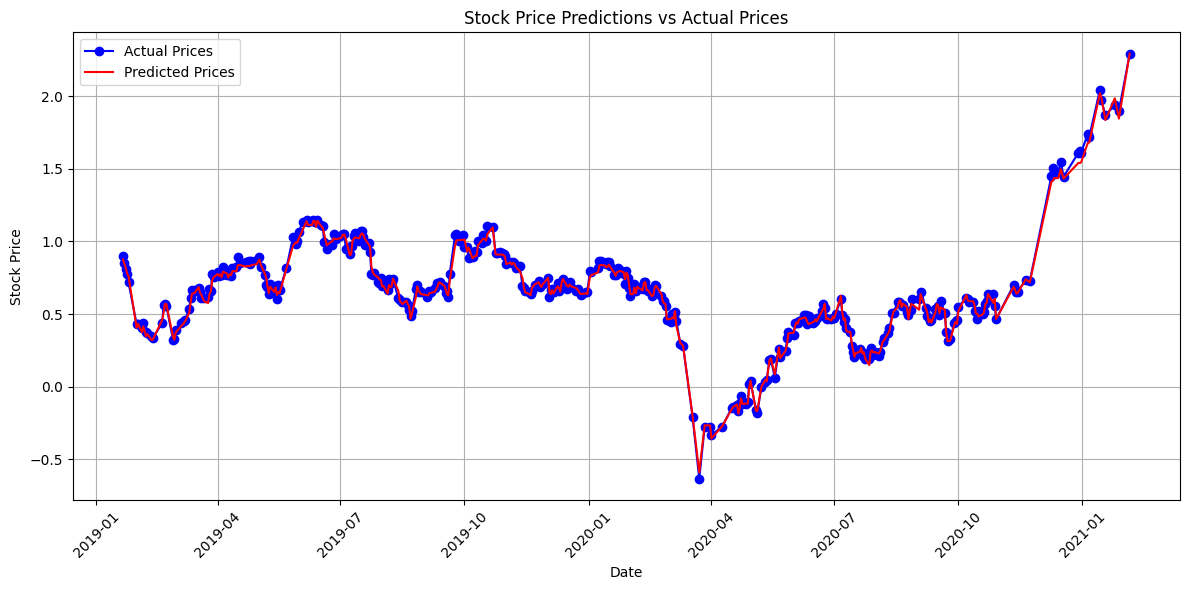

In [ ]:
# TEST dates
start_validation_date = '2019-01-21'
end_validation_date = '2021-02-05'
#2019-01-21 00:00:00 to 2021-02-05 00:00:00
# Filter the date array for the validation period
plot_date_y = date[(date >= start_validation_date) & (date <= end_validation_date)]

#Visiualizing the predictions
plot_y_test = np.array(y_test)
plot_test_predictions = np.array(test_predictions)

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(plot_date_y,plot_y_test, label='Actual Prices', color='blue', marker='o')
plt.plot(plot_date_y,plot_test_predictions, label='Predicted Prices', color='red', linestyle='-',)

# Adding titles and labels
plt.title('Stock Price Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#using the manual model
test2_predictions = model.predict(test_x)
test2_mse = mean_squared_error(test_y, test2_predictions)
test2_rmse = np.sqrt(test2_mse)
test2_mae = mean_absolute_error(test_y, test2_predictions)
test2_r2 = r2_score(test_y, test2_predictions)
test2_mape = mean_absolute_percentage_error(test_y, test2_predictions)
print(f"Mean Squared Error: {test2_mse}")
print(f"Root Mean Squared Error: {test2_rmse}")
print(f"Mean Absolute Error: {test2_mae}")
print(f"r2: {test2_r2}")
print(f"MAPE: {test2_mape}")


Mean Squared Error: 0.047066794317899785
Root Mean Squared Error: 0.21694882880047955
Mean Absolute Error: 0.12599037721106598
r2: 0.9529332056821003
MAPE: 0.3807445082867758


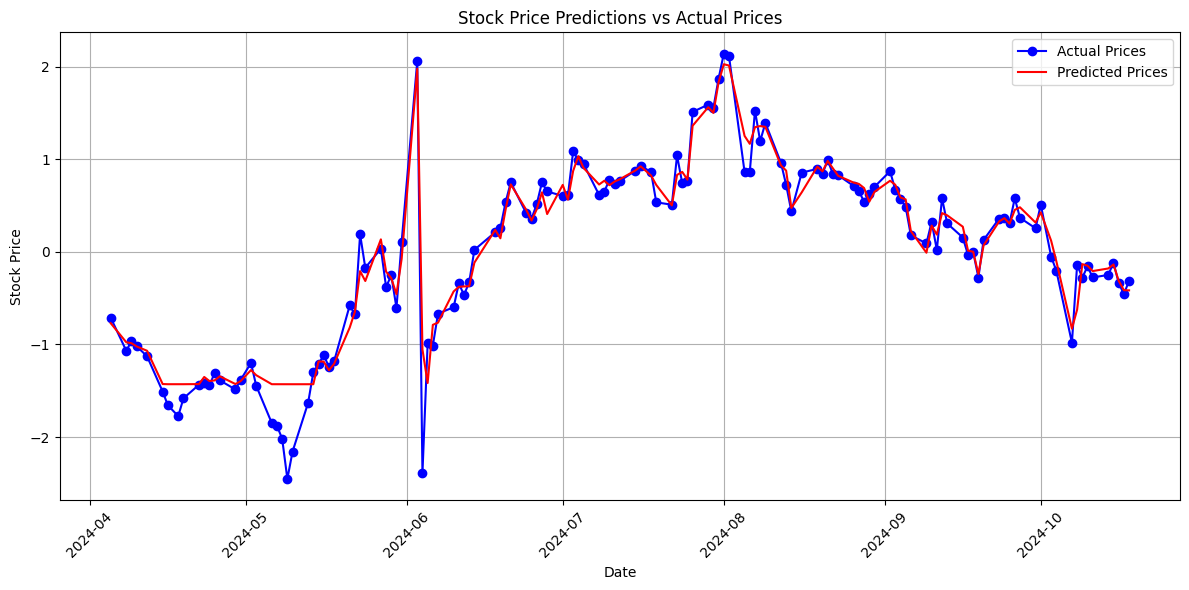

In [ ]:
# TEST dates
start_test_date = '2024-04-05'
end_test_date = '2024-10-18'
#2019-01-21 00:00:00 to 2021-02-05 00:00:00
# Filter the date array for the validation period
plot_date_test_y = date2[(date2 >= start_test_date) & (date2 <= end_test_date)]

#Visiualizing the predictions
plot_test_y = np.array(test_y)
plot_test_y_predictions = np.array(test2_predictions)

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(plot_date_test_y,plot_test_y, label='Actual Prices', color='blue', marker='o')
plt.plot(plot_date_test_y,plot_test_y_predictions, label='Predicted Prices', color='red', linestyle='-',)

# Adding titles and labels
plt.title('Stock Price Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
#plt.xlim([])

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#using best estimator model
test3_predictions = best_estimator.predict(test_x)
test3_mse = mean_squared_error(test_y, test3_predictions)
test3_rmse = np.sqrt(test3_mse)
test3_mae = mean_absolute_error(test_y, test3_predictions)
test3_r2 = r2_score(test_y, test3_predictions)
test3_mape = mean_absolute_percentage_error(test_y, test3_predictions)
print(f"Mean Squared Error: {test3_mse}")
print(f"Root Mean Squared Error: {test3_rmse}")
print(f"Mean Absolute Error: {test3_mae}")
print(f"r2: {test3_r2}")
print(f"MAPE: {test3_mape}")

Mean Squared Error: 0.04628990023012232
Root Mean Squared Error: 0.2151508778279148
Mean Absolute Error: 0.12422199580192507
r2: 0.9537100997698776
MAPE: 0.3836310139900283


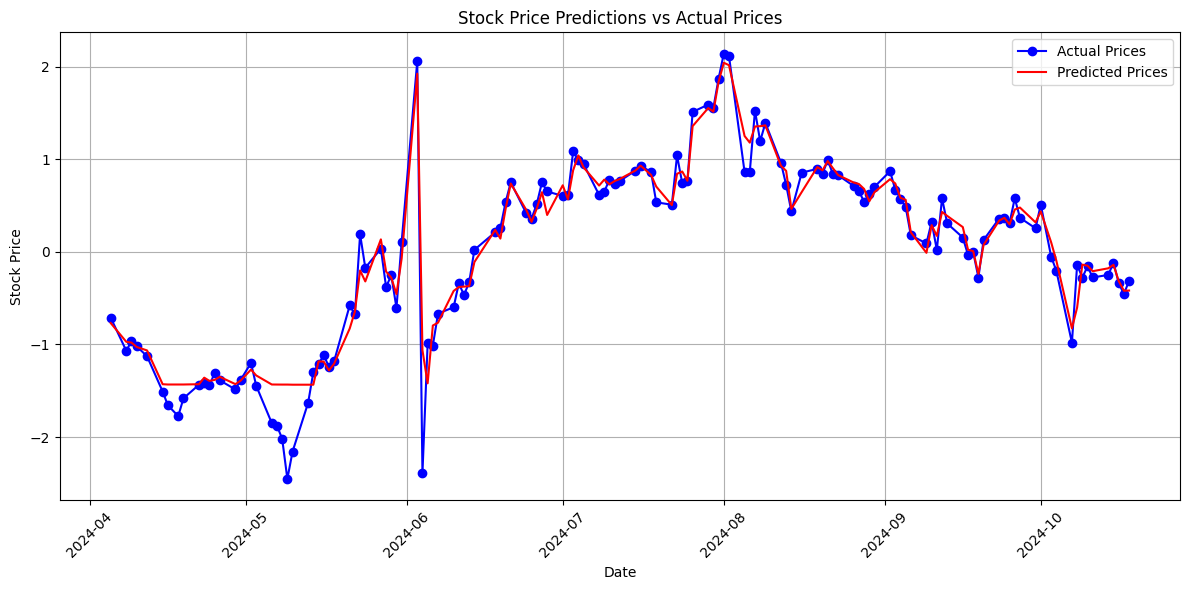

In [ ]:
# TEST dates
start_test_date = '2024-04-05'
end_test_date = '2024-10-18'
#2019-01-21 00:00:00 to 2021-02-05 00:00:00
# Filter the date array for the validation period
plot_date_test3_y = date2[(date2 >= start_test_date) & (date2 <= end_test_date)]

#Visiualizing the predictions
plot_test3_y = np.array(test_y)
plot_test3_y_predictions = np.array(test3_predictions)

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(plot_date_test3_y,plot_test3_y, label='Actual Prices', color='blue', marker='o')
plt.plot(plot_date_test3_y,plot_test3_y_predictions, label='Predicted Prices', color='red', linestyle='-',)

# Adding titles and labels
plt.title('Stock Price Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
#plt.xlim([])

# Show the plot
plt.tight_layout()
plt.show()